In [1]:
from numba import cuda
from numba import void, uint8 , uint32, uint64, int32, int64, float32, float64, f8
import numpy as np
import math
from matplotlib import animation
import matplotlib.pyplot as plt
%matplotlib notebook

device = cuda.get_current_device()

In [2]:
@cuda.jit('void(float32[:],float32,float32,float32,float32,float32,float32[:],float32[:] ,float32[:], uint32)',device = True)
def calcLocalJs(uvals,P,Q,R,vjsqrinv,dj,quadCoeffs,JLvals,JRvals ,JSize):
        #do a finite difference stencil for the second derivative at every point
        #in our mesh. do a 4 point stencil at the ends to preserve accuracy
        j = cuda.threadIdx.x

        if j != 0 and j != (JSize-1):
            quadCoeffs[j]= (uvals[j-1] - 2*uvals[j] + uvals[j+1])*vjsqrinv 
        elif j == 0:
            quadCoeffs[j] = (2*uvals[0] - 5*uvals[1] + 4*uvals[2] - uvals[3])*vjsqrinv
        else:
            quadCoeffs[j] = (2*uvals[JSize-1] - 5*uvals[JSize-2] +4*uvals[JSize-3] - uvals[JSize-4])*vjsqrinv
        #evaluate the polynomial integral for each J between 0 and N.

        if j != 0:
            #recursive formula to update the value of J
            JLcurr  = P*uvals[j] + Q*uvals[j-1] + quadCoeffs[j]*R
            JLvals[j] = JLcurr

        if j != JSize-1:
            JRreverse = P*uvals[-(j+2)]+Q*uvals[ -(j+1) ] + R*quadCoeffs[-(j+2)] 
            JRvals[JSize-j-2] = JRreverse


        

In [48]:
"""
solve the local pieces of the wave equation in 1d and return the end points of this calculation
each thread is going to solve a local piece of the wave equation and return an end point

a list or matrix of values is passed in where each column of the matrix and list corresponds
to the value of that segment

after we are done computing the local contributions, pass the values back to the cpu to calculate
the nonlocal contribution values

INPUTS:
uvalsMatrix      - a 2d Array of the value of u for each segment
Plist            - the values of P in our quadrature
Qlist            - the values of Q in our quadrature
Rlist            - the values of R in our quadrature
vjInvList        - the values of 1/vj**2 in our quaderature
djlist           - the values of dj in our quadrature
quadCoeffsMatrix - an empty 2d array of size(uvalsMatrix) that stores finite difference stencils
JLValMatrix      - an empty 2d array of size(uvalsMatrix) that stores the lefthand convolution
JRValMatrix      - an empty 2d array of size(uvalsMatrix) that stores the righthand convolution
JSizeList        - how large is each uvals array (may be unneccessary should be constant currently)

OUTPUTS:
wMatrix   - a 2d array of size(uvalsMatrix) that stores the sum of left+right convolution
leftComm  - a 1d array of size(domainCount) that stores the left side communication coefficients
rightComm - a 1d array of size(domainCount) that stores the right side communication coefficients

"""
@cuda.jit('void(float32[:,:],float32[:],float32[:],float32[:],float32[:] , float32[:], float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:],float32[:],uint32[:])')
def uLocal1D(uvalsMatrix, Plist , Qlist , Rlist
             , vjInvList , djlist 
             , quadCoeffsMatrix , JLvalMatrix 
             , JRvalMatrix      , wMatrix 
             , leftComm          , rightComm 
             , JSizeList):
    
    i = cuda.blockIdx.x
    j = cuda.threadIdx.x
    JSize    = JSizeList[i]    
    P        = Plist[i]
    Q        = Qlist[i]
    R        = Rlist[i]
    vjsqrinv = vjInvList[i]
    dj       = djlist[i]
    
    MachineEpsilon = 1e-12
    
    n              = math.ceil(math.log(MachineEpsilon)/math.log(dj))
    calcLocalJs(uvalsMatrix[i,:],P,Q,R,vjsqrinv,dj,quadCoeffsMatrix[i,:],JLvalMatrix[i,:],JRvalMatrix[i,:] , JSize)
    
    cuda.syncthreads()
    #wait for all threads to finish

    power = 1
    currJL = JLvalMatrix[i][j]
    currJR = JRvalMatrix[i][j]
    djpower = dj
    while power <= n:
        if j-power >= 0:
            currJL += JLvalMatrix[i][j-power]*djpower
        if j+power < JSize:
            currJR += JRvalMatrix[i][j+power]*djpower

        power += 1
        djpower *= dj

    JLvalMatrix[i][j]         = currJL
    JRvalMatrix[i][j] = currJR
    
    cuda.syncthreads()
    
    wMatrix[i,j] = JLvalMatrix[i,j] + JRvalMatrix[i,j]
    
    cuda.syncthreads()
    
    if j == 1:
        leftComm[len(uvalsMatrix) - i - 1] = wMatrix[i][0]
        rightComm[i]  = wMatrix[i][JSize-1]
        
    cuda.syncthreads()

In [49]:
"""
this function should change to whatever the source function is 
f(x,y)*dt*exp(-alpha*abs(x-midpoint))
"""
@cuda.jit('float32(float32,float32,float32,float32,float32)',device = True)
def sourceTerm(dt,time,alpha,x,wVal):
    return 10*(math.tanh(20*time-40)**2-math.tanh(20*time-20)**2)*dt*math.exp(-alpha*abs(x))
    #print (wVal)

In [50]:
@cuda.jit('void(float32[:,:],float32[:,:],float32[:,:],float32,float32, float32[:,:],float32[:],float32[:],float32, float32,float32[:],float32[:])')
def uUpdate1D(uvalsMatrix, wMatrix, xvals ,dt, time, uPrevMatrix,A,B,alpha,beta,a,b):
    j = cuda.threadIdx.x
    i = cuda.blockIdx.x
    
    wMatrix[i,j] = wMatrix[i,j]+A[i]*math.exp(-alpha*(xvals[i,j] - a[i] ) ) + B[i]*math.exp(-alpha *(b[i]  - xvals[i,j]))
    
    wMatrix[i,j] += sourceTerm(dt,time,alpha,xvals[i,j] , wMatrix[i,j])
    
    wMatrix[i,j] = uvalsMatrix[i,j] - .5*wMatrix[i,j]
    wMatrix[i,j] = 2*uvalsMatrix[i,j] - uPrevMatrix[i,j] - beta**2*wMatrix[i,j]
    uPrevMatrix[i,j] = uvalsMatrix[i,j]
    uvalsMatrix[i,j] = wMatrix[i,j]
    
    cuda.syncthreads()

In [51]:
"""
This is an object which will solve a segment of a distributed wave soln

xvals - the domain which is covered(Note: only uniform grids are allowed)
f     - the function describing the initial state
g     - the function describing the initial time derivative
alpha - decay parameter
c     - speed of propogation c 
cfl   - cfl condition
"""
class lineSeg:
    def __init__(self, xdomain, f,g,c,cfl):
        self.beta_  = 2
        self.xvals_ = xdomain
        self.h_    = self.xvals_[1]-self.xvals_[0]
        self.a_     = self.xvals_[0]
        self.b_     = self.xvals_[-1]
        #self.dt_    = self.h_/c*cfl
        #self.alpha_ = self.beta_/(c*self.dt_)
        self.uprev_ = np.zeros_like(self.xvals_,dtype = np.float32)
        self.ucurr_ = np.zeros_like(self.xvals_,dtype = np.float32)
        self.c_     = c
        self.f_     = f
        self.g_     = g
        
    def getAlphaDistance(self):
        return self.alpha_*(self.b_-self.a_)
    
    def __len__(self):
        return len(self.xvals_)
    """the first timestep is done with a 2nd order taylor expansion"""
    def taylorStep(self):
        #we need to set the initial state 
        for i , xi in enumerate(self.xvals_):
            fval = np.float32(self.f_(xi))
            self.uprev_[i] = fval
            #self.ucurr_.append(fval + self.dt_*g(xi))
            self.ucurr_[i] = np.float32(1/2*(self.f_(xi-self.c_*self.dt_)+ self.f_(xi+self.c_*self.dt_) + self.dt_*(self.g_(xi-self.c_*self.dt_)+self.g_(xi+self.c_*self.dt_))))
        #self.ucurr_[0] = (self.ucurr_[0]+self.ucurr_[-1])/2
        #self.ucurr_[-1] = self.ucurr_[0]
    
    """time steps cannot be determined until all subgrids are made"""
    def setTimestep(self , dt):
        self.dt_ = dt
        self.alpha_ = self.beta_/(self.c_*self.dt_) 
        
        self.calcUniformQuadWeights()
        self.taylorStep( )
       
    """the the mesh is not adaptive, many constants are the same"""
    def calcUniformQuadWeights( self ):
            
            #assume uniform step size
            
            self.vj_    = self.alpha_*self.h_
            self.dj_    = math.exp(-self.vj_) 
            
            ratio = (1-self.dj_)/self.vj_
            eps = 1e-3
            self.Q_     = -self.dj_ + ratio

            #if things get small, this blows up 
            if self.vj_>eps:
                self.P_ = 1 - ratio
                self.R_ = 1-self.dj_-self.vj_/2*(1+self.dj_ )
            else:
                self.P_ = (self.h_/2-self.h_**2/6+self.h_**3/24-self.h_**4/120)
                self.R_ = -math.exp(-self.h_/2)*(self.h_**3/12+self.h_**5/480+self.h_**7/53760)            
    
    """get the current value of u"""
    def getState(self):
        return self.ucurr_
    
    def getDist(self):
        return self.h_
    
    def updateSoln(self, newU,newPrev):
        self.ucurr_ = newU
        self.uprev_ = newPrev
    

In [52]:
"""
solve the wave equation on a 1D line

xdomains - a list of list of xdomains
f        - the function describing the initial state
g        - the function describing the initial time derivative
c        - speed of wave propogation
cfl      - relationship between the time and spatial discretization
bcs      - what type of boundary conditions do we have?
"""

class lineSolve:
    def __init__(self,xdomains, f, g , c , cfl , bcs):

        self.beta_ = 2
        self.bcType_ = bcs
        self.lineSegs_ = []
        self.domainSize_ = xdomains[-1][-1]-xdomains[0][0]
        
        #find out what the smallest x grid is
        self.minSize_ = len(xdomains[0])
        
        for xdomain in xdomains:
            dsize = len(xdomain)
            
            if dsize<self.minSize_:
                self.minSize_ = dsize
        
        #NOTE current behavior is to split and resize domains(upwards) until 
        #we have equal sized domains 
        
        #additionally we need to determine what our step size in time will be
        self.dt_ = 5 
        for xdomain in xdomains:
            dsize = len(xdomain)

            if dsize != self.minSize_:
                newDomains = self.splitDomain(xdomain,dsize)
                
                for newDomain in newDomains:
                    newLineSeg = lineSeg(newDomain,f,g,c,cfl)
                    
                    dtCandidate = newLineSeg.getDist()*cfl/c
                    if self.dt_ > dtCandidate:
                        self.dt_ = dtCandidate
                    
                    self.lineSegs_.append(newLineSeg)
            else:
                newLineSeg = lineSeg(xdomain,f,g,c,cfl)
                dtCandidate = newLineSeg.getDist()*cfl/c
                
                if self.dt_ > dtCandidate:
                    self.dt_ = dtCandidate
                
                self.lineSegs_.append(newLineSeg)

        # these parameters are used in calculating the values at the boundary
        self.alpha_ = self.beta_/(c*self.dt_)
        self.damping_ = math.exp(-self.alpha_*(self.domainSize_))

        #now that we know what dt is, we need to 
        for segment in self.lineSegs_:
            segment.setTimestep(self.dt_)
        
        self.nDomains_ = len(self.lineSegs_)
        self.time_ = self.dt_
        
        print(self.nDomains_*self.minSize_)
        
        self.numThreads_ = self.nDomains_
        self.numBlocks_ = 1
        if self.numThreads_ > device.WARP_SIZE:
            print("you just hit your performance you fool!")
        
        #figure out how to put it onto multiple blocks if it gets too big. 
        #shouldn't hit performance too much since there isn't much shared memory between
        #subdomains
        
        #one idea is to just make a 'struct' that holds the cuda device memory for each block,
        #then merge everything back together in the end
        
    """
    if the domain is larger than the minimum size, then we want to split it up and resize it
    until we have some number of domains that is each the minimum size
    this is done for load balancing on the gpu
    """   
    def splitDomain(self,xdomain,dsize):
        #get the beginning and end of the domain
        a     = xdomain[0]
        b     = xdomain[-1]
        
        if dsize%self.minSize_ != 0:
            print("domain not integer multiple, resizing")
            dsize = dsize + dsize%self.minSize_
        
        nDomains = int(dsize/self.minSize_) 
        stepSize = (b-a)/nDomains
        
        newDomains = [np.linspace(a+(i)*stepSize,a+(i+1)*stepSize,self.minSize_,dtype = np.float32) for i in range(nDomains)]
        return(newDomains)
    """
    waveHandler should know about the BC's, segments shouldn't have any idea
    what the boundary conditions are, this will set the correct bc conditions
    """
    def applyBCs(self, leftEnds , rightEnds):
        if self.bcType_ == 'periodic':
            self.BC1_ = leftEnds/(1-self.damping_)
            self.BC2_ = rightEnds/(1-self.damping_)
    

    """
    need to put variables on the GPU, this should only get called once, use updateCUDAdeviceMemory
    for all other needs

    BECAUSE NUMBA has garbage collection we cannot manage memory as much as i'd like
    and have to do everything locally in this context
    """
    def calcTimeStep(self):
        self.time_ += self.dt_
        
        emptyMatrix    = np.zeros((self.nDomains_ , self.minSize_ ),dtype = np.float32)
        emptyList      = np.zeros(self.nDomains_,dtype=np.float32)


        ##NOTE All of the following values were written for convenience, 
        #      if it's a performance issue, put everything into 1 loop
        hxvals_ = np.array([segment.xvals_ for segment in self.lineSegs_],dtype =np.float32)
        self.hxvals_= hxvals_
        ha_     = np.array([segment.a_ for segment in self.lineSegs_], dtype = np.float32)
        hb_     = np.array([segment.b_ for segment in self.lineSegs_], dtype = np.float32)

        #store the information on the host
        hUValsMatrix  = np.array([segment.getState() for segment in self.lineSegs_], dtype = np.float32)
        hUPrevMatrix  = np.array([segment.uprev_ for segment in self.lineSegs_],dtype = np.float32)


        hPlist = np.array([segment.P_ for segment in self.lineSegs_],dtype = np.float32)
        hQlist = np.array([segment.Q_ for segment in self.lineSegs_],dtype = np.float32)
        hRlist = np.array([segment.R_ for segment in self.lineSegs_],dtype = np.float32)

        hvjInvList = np.array([1/segment.vj_**2 for segment in self.lineSegs_],dtype = np.float32)
        hdjlist    = np.array([segment.dj_ for segment in self.lineSegs_],dtype = np.float32)

        hquadCoeffsMatrix = emptyMatrix
        hJLvalMatrix = emptyMatrix
        hJRvalMatrix = emptyMatrix

        hwMatrix    = emptyMatrix
        hleftComm    = emptyList
        hrightComm  = emptyList

        hJSizeList  = np.array([len(segment) for segment in self.lineSegs_],dtype = np.uint32)#should be constant currently
        
        # transfer all the data to the device
        
        dUValsMatrix  = cuda.to_device(hUValsMatrix)
        dPlist = cuda.to_device(hPlist)
        dQlist = cuda.to_device(hQlist)
        dRlist = cuda.to_device(hRlist)
        
        dvjInvList = cuda.to_device(hvjInvList)
        ddjlist    = cuda.to_device(hdjlist)

        dquadCoeffsMatrix = cuda.to_device(hquadCoeffsMatrix)
        dJLvalMatrix = cuda.to_device(hJLvalMatrix)
        dJRvalMatrix = cuda.to_device(hJRvalMatrix)

        dwMatrix    = cuda.to_device(hwMatrix)
        dleftComm   = cuda.to_device(hleftComm)
        drightComm  = cuda.to_device(hrightComm)

        dJSizeList  = cuda.to_device(hJSizeList)
     
        uLocal1D[self.nDomains_,hJSizeList[0]](dUValsMatrix, dPlist 
             , dQlist            , dRlist
             , dvjInvList        , ddjlist 
             , dquadCoeffsMatrix , dJLvalMatrix 
             , dJRvalMatrix      , dwMatrix 
             , dleftComm         , drightComm 
             , dJSizeList)
        self.hleftComm  = dleftComm.copy_to_host()
        self.hrightComm = drightComm.copy_to_host()

        self.updateTransmissionCoeffs()

        dA_ = cuda.to_device(self.hA_)
        dB_ = cuda.to_device(self.hB_)

        da_          = cuda.to_device(ha_)
        db_          = cuda.to_device(hb_)
        dxvals_      = cuda.to_device(hxvals_)
        dUPrevMatrix = cuda.to_device (hUPrevMatrix)
           
        uUpdate1D[self.nDomains_, hJSizeList[0]](dUValsMatrix, dwMatrix, dxvals_ , self.dt_,
                   self.time_ , dUPrevMatrix,dA_,dB_,self.alpha_,self.beta_,da_,db_)

        hUValsMatrix = dUValsMatrix.copy_to_host()
        hUPrevMatrix  = dUPrevMatrix.copy_to_host()
        
        for index in range(self.nDomains_):
            self.lineSegs_[index].updateSoln(hUValsMatrix[index],hUPrevMatrix[index])
      
    
    """
    after calculating the local contributions in cuda, we need to update
    the boundaries 
    """
    def updateTransmissionCoeffs(self):
        self.hA_    = np.zeros_like(self.hleftComm,dtype = np.float32)
        self.hB_    = np.zeros_like(self.hrightComm,dtype = np.float32)
        
        JL = self.hrightComm[0]
        JR = self.hleftComm[0]
        
        distanceScalar = 1
        
        for segmentIndex in range(1,self.nDomains_):
            segment  = self.lineSegs_[segmentIndex]
            expAlphaDistance = math.exp(-segment.getAlphaDistance())
            
            self.hA_[segmentIndex] = JL
            self.hB_[self.nDomains_-segmentIndex-1]=JR
            
            distanceScalar*=expAlphaDistance
            
            JL = JL*distanceScalar + self.hrightComm[segmentIndex]
            JR = JR*distanceScalar + self.hleftComm[segmentIndex]
        
        self.applyBCs(JL,JR)
        
        distanceScalar = 1
        
        for segmentIndex , segment in enumerate(self.lineSegs_):
            self.hA_[segmentIndex] += distanceScalar*self.BC1_
            self.hB_[self.nDomains_-segmentIndex-1] += distanceScalar*self.BC2_

            expAlphaDistance = math.exp(-segment.getAlphaDistance())
            distanceScalar *=expAlphaDistance
    
    def propogate(self):
        self.calcTimeStep()
        self.meshSolns()
        
    def meshSolns(self):
        self.allSolns_ = []
        #to properly mesh grids together
        #if it's even, then take the left endpoint off 
        #if it's odd, then take the right endpoint off
        for segmentIndex,segment in enumerate(self.lineSegs_):
            if segmentIndex == 0:
                self.allSolns_+= list(segment.getState())
            else:
                self.allSolns_+=list(segment.getState()[1:len(segment)])

    def getXSize(self):
        self.allX_ = []
        #to properly mesh grids together
        #if it's even, then take the left endpoint off 
        #if it's odd, then take the right endpoint off
        for segmentIndex,segment in enumerate(self.hxvals_):
            if segmentIndex == 0:
                self.allX_+= list(segment)
            else:
                self.allX_+=list(segment[1:len(segment)])
        return self.allX_
    def getSolns(self):
        return self.allSolns_

In [53]:

a = -2
b = 2
N = 64
x1 = np.linspace(-2, -1.75, N)
x2 = np.linspace(-1.75, -1.0 , N)
x3 = np.linspace(-1.0, -.5 , N)
x4 = np.linspace(-.5 , 0 , N)
x5 = np.linspace(0 , .5 , N)
x6 = np.linspace(.5 , 1 , N)
x7 = np.linspace(1 , 1.5 , N)
x8 = np.linspace(1.5 , 2 , N)
#x1 = np.linspace(-2, 0, N,dtype = np.float32)
#x2 = np.linspace(0, 2 , N,dtype = np.float32)

f = lambda x: 0#math.exp(-72*((x-(a+b)/2)/(b-a))**2)
g = lambda x: 0#144/(b-a)**2*(x-(a+b)/2)*math.exp(  -72*( (x-(a+b)/2) / (b-a) )**2)

c = 1
cfl = 4
bcs = "periodic"

solver = lineSolve([x1,x2,x3,x4,x5,x6,x7,x8], f, g , c , cfl , bcs)
uSoln = []
for i in range(100):
    solver.propogate()
    uSoln.append(solver.getSolns())
x = solver.getXSize()

512


<IPython.core.display.Javascript object>


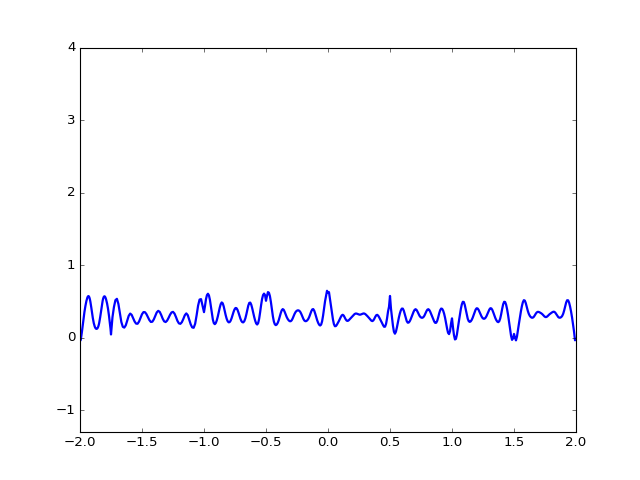

In [54]:
def animate(i):
    line.set_data(x,uSoln[i])
    return line,
def init():
    line.set_data([], [])
    return line,
fig   = plt.figure()
ax    = plt.axes(xlim=(-2,2),ylim = (-1.3,4))
line, = ax.plot([],[] , lw=2)
anim = animation.FuncAnimation(fig,animate, blit=True)